# Social Network Analysis
## Sean O'Malley

------------------------------------------------

The intent of this analysis is to be able to take a large network of undirected connections and make sense of that network, while also giving shape to the possible networks within. This entire analysis is framed as a test case for maximizing understanding of a community given minimal input. 

This analysis is of interest to me as I have most recently been volunteering, researching and practicing data science in the poorest areas of Perú, with a specific focus on the communities of Pamplona Alta and Ayaviri with the aim of __understanding urban and rural poverty__ in the developing world better. We hope to one day be able to map and __interpret community structures__ in order to help them more. 

The analysis used is __network analysis__, which comes from the concept of network (graph) theory. Network theory is the representation of symmetric relations between discrete objects. This analysis can be used to graph and understand various social and transportation networks. Primarily, network analysis helps us model relationships between entities, determine entity importance and find community structures within a network. 

The test data used is a list of __Facebook__ friend relationships from <a href="http://snap.stanford.edu/data/ego-Facebook.html">Stanford Network Analysis Project</a>, and using this data we aim to perform the following analyses:

* _Understand the Network Structure_
    * Nodes
    * Edges
    * Degree 
    * Degree Centrality
    * Betweenness Centrality
    
* _Visualize the Network_
    * Matrix
    * Circos
    * Arc

* _Find Groups Within the Network_
    * Triangles
    * Cliques
    * Maximal Cliques
    
* _Explore Subsets of Interest_

* _Determine the Network Influencers_
    * Characteristics
    * Visualize
    
* _Recommend Friend Connections_
    * Open Triangles

* _Summary_

* _Challenges & Lessons Learned_

------------------------------------------------

_The data has been anonymized by replacing the Facebook internal ids with new values_

------------------------------------------------


### Import Packages : _Facebook Network Analysis_

In [1]:
import os
from glob import iglob
import numpy as np 
import pandas as pd
import networkx as nx
import gzip
import matplotlib.pyplot as plt

In [2]:
import nxviz as nv
from networkx.algorithms import community as nxc

### Ingestion : _Facebook Network Analysis_

In [3]:
# Read in file, cast as string for cleaning
f = gzip.open('facebook_combined.txt.gz','rb')
content = str(f.read())
f.close()

# Clean up and cut off messy bookends
content = content[4:-8]
content = content.replace("\\n",",")
content = content.replace(" ",";")
content = content.split(";")
    
# Initialize Lists
output = []
clean = []
    
# Build list of lists
for i in content:
    x = i.split(",") 
    output.append(x)
        
# Cast as integers  
clean = [[int(x) for x in y] for y in output]

__Quick irregularity check__

We built two lists then concatenated to determine a count of all nodes mentioned in our original list of lists in order to spot any irregularities on ingestion.

In [150]:
list0 = []
list1 = []

for i in range(len(clean)):
    x = clean[i][0]
    list0.append(x)
    
for i in range(len(clean)):
    x = clean[i][1]
    list1.append(x)
    
qq = list0 + list1

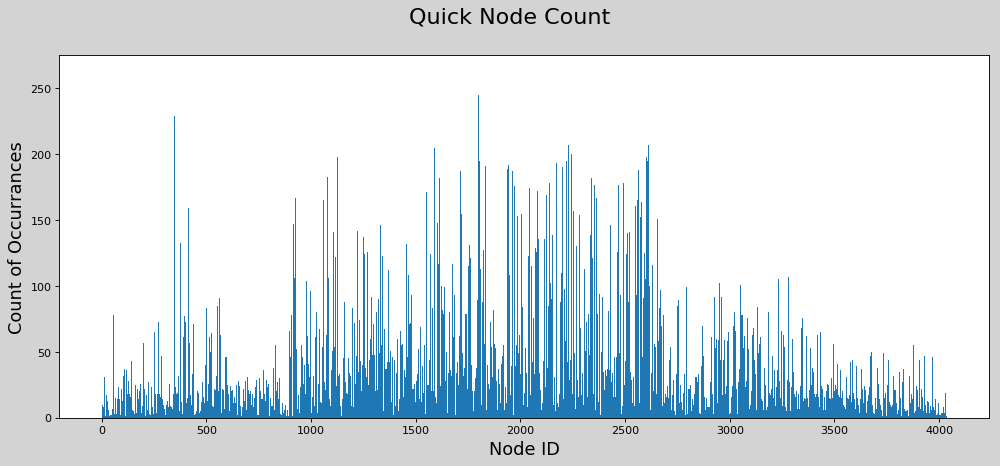

In [161]:
plt.figure(figsize=(15, 6), dpi=80, facecolor='lightgray')
plt.hist(qq, bins = list(np.arange(0, len(list(set(qq))), 1)))
plt.suptitle('Quick Node Count', fontsize=20)
plt.xlabel('Node ID', fontsize=16)
plt.ylabel('Count of Occurrances', fontsize=16)
plt.ylim((0,275))
plt.show()

### Understand : _Facebook Network Analysis_
#### Statistical Data Exploration

In [4]:
g = nx.Graph()
g.add_edges_from(clean)

In [5]:
print("------------------------------------------")
print("The network has " + str(len(g.nodes())) + " nodes and " + str(len(g.edges())) + " edges. Confirming SNAP data structure.")
print("------------------------------------------")

------------------------------------------
The network has 4039 nodes and 88074 edges. Confirming SNAP data structure.
------------------------------------------


##### Remove Self Loops

We want to take a quick moment to find and remove any self loops. A self loop is a node connected to itself. We don't want these in our Facebook analysis because a self loop means someone who is friends with themselves. 

In [6]:
def find_selfloop_nodes(a):
    
    nodes_in_selfloops = []
    
    # Iterate over all the edges of G
    for k, v in a.edges(data=False):
        if k == v:
            nodes_in_selfloops.append(k)
            
    return nodes_in_selfloops

In [7]:
print("------------------------------------------")
print("We can see we have " + str(g.number_of_selfloops()) + " self loops that need to be removed.")
print(str(find_selfloop_nodes(g)))
print("------------------------------------------")

------------------------------------------
We can see we have 6 self loops that need to be removed.
[339, 1254, 1894, 657, 809, 2642]
------------------------------------------


In [8]:
g.remove_edges_from(g.selfloop_edges())

In [9]:
print("------------------------------------------")
print("We now have " + str(g.number_of_selfloops()) + " self loops remaining.")
print("------------------------------------------")

------------------------------------------
We now have 0 self loops remaining.
------------------------------------------


##### Degree 

The degree of a node in a network is the number of connections it has, while the degree distribution is the probability distribution of the degrees of nodes across the entire network.

To explore the degree of nodes from a high level, I have created a UDF to find the number of nodes given a number of connections. I placed this UDF into a loop in order to get a distribution of nodes by neighbor count.

In [10]:
def nodes_with_neighbors(a,m):
    nodes = set()
    for n in a.nodes(data=False):
        if len(list(a.neighbors(n))) == m:
            nodes.add(n)
    return nodes

We need to understand the distribution of degree across nodes, meaning that we have to determine a count of nodes given a number of neighbors. To do so we placed our UDF into a loop that creates a list of node counts, given x amount of neighbors. We selected the range of 0 to 200 neighbors to visualize.

In [11]:
n = 0
neb_num = []

for n in range(201):
    x = len(nodes_with_neighbors(g, m = n))
    neb_num.append(x)
    n += 1
    
neb = pd.DataFrame()
neb['n_neighbors'] = list(range(201))
neb['n_nodes'] = neb_num

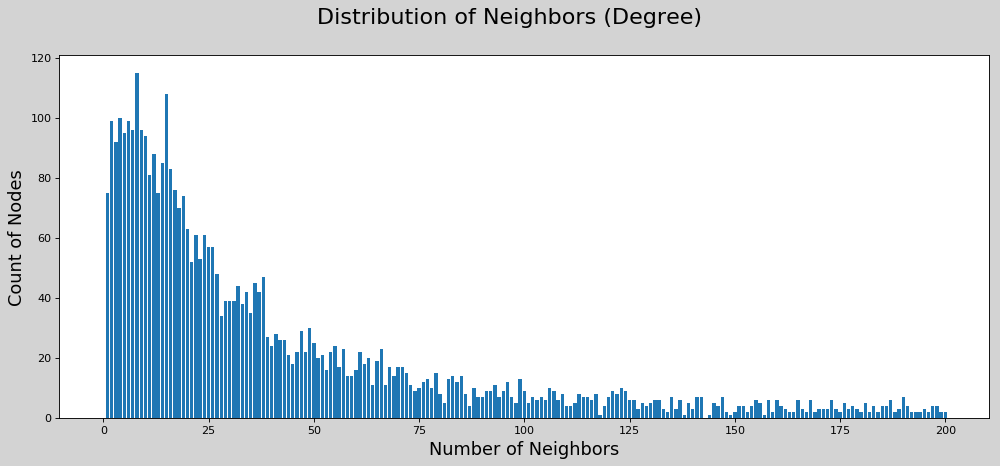

In [12]:
plt.figure(figsize=(15, 6), dpi=80, facecolor='lightgray')
plt.bar(neb['n_neighbors'],neb['n_nodes'])
plt.suptitle('Distribution of Neighbors (Degree)', fontsize=20)
plt.xlabel('Number of Neighbors', fontsize=16)
plt.ylabel('Count of Nodes', fontsize=16)
plt.show()

##### Degree Centrality

The degree centrality takes the degree process a step further, by giving an importance score based on the number of links held by each node. Providing a measure of node connectivity in a simple equation

> __degree centrality__ = number of neighbors / number of total possible neighbors

In [13]:
dc = nx.degree_centrality(g)

In [51]:
dc_v = list(dc.values())

In [54]:
print("---------------------")
print("The median is " + str(np.median(dc_v)) + " and the mode is " + str(np.mean(dc_v)))
print("Meaning that, " + str(np.mean(dc_v)>np.median(dc_v)) + ", the dc mean is higher than the median and the distribution is positively skewed.")
print("---------------------")

---------------------
The median is 0.006191183754333828 and the mode is 0.010799607246876387
Meaning that, True, the dc mean is higher than the median and the distribution is positively skewed.
---------------------


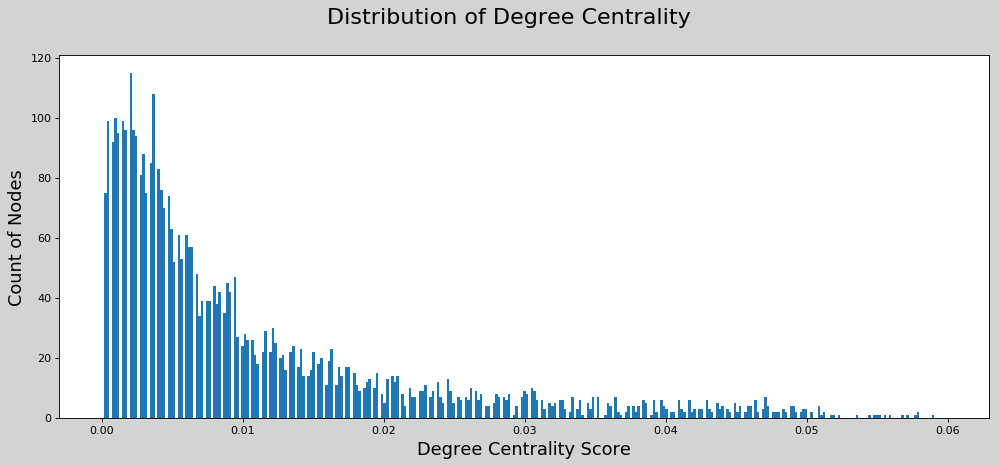

In [60]:
plt.figure(figsize=(15, 6), dpi=80, facecolor='lightgray')
plt.hist(list(dc.values()),bins = list(np.arange(0, 0.06, 0.00018)))
plt.suptitle('Distribution of Degree Centrality', fontsize=20)
plt.xlabel('Degree Centrality Score', fontsize=16)
plt.ylabel('Count of Nodes', fontsize=16)
plt.show()

The graph above lets us know that the majority of nodes have a degree centrality score below 0.01, which is ordinarily low, so there may be more to explore with the ways in which these nodes are connected.

_Top Performing DC_

Given this largest network view, lets determine the node with the highest degree centrality score. Do do so, we'll make a UDF.

In [22]:
def highest_deg_cent(a):
    
    dc = nx.degree_centrality(a)
    
    max_dc = max(list(dc.values()))
    
    nodes = set()
    
    for k, v in dc.items():
        if v == max_dc:
            nodes.add(k)
            
    return (nodes,max_dc)

In [32]:
best_dc_n,best_dc = highest_deg_cent(g)

In [39]:
print("---------------------")
print("Node " +  str(list(best_dc_n)[0]) + " had the highest centrality score of " + str(round(best_dc,4)))
print("---------------------")

---------------------
Node 107 had the highest centrality score of 0.2588
---------------------


##### Betweenness Centrality 

Betweenness centrality is based on the concept of the shortest path, which states, for every pair of nodes in a connected graph there is a shortest path available between the those nodes. The betweenness centrality score is a quantification of the count of shortest paths that pass through a specific node. Thus, the betweenness centrality score works as another measure for node (user) importance. 


In [43]:
bc = nx.betweenness_centrality(g)

In [57]:
bc_v = list(bc.values())
bc_k = list(bc.keys())

In [58]:
print("---------------------")
print("The median is " + str(np.median(bc_v)) + " and the mode is " + str(np.mean(bc_v)))
print("Meaning that, " + str(np.mean(bc_v)>np.median(bc_v)) + ", the bc mean is higher than the median and the distribution is positively skewed.")
print("---------------------")

---------------------
The median is 6.578615388887847e-06 and the mode is 0.0006389049066857799
Meaning that, True, the bc mean is higher than the median and the distribution is positively skewed.
---------------------


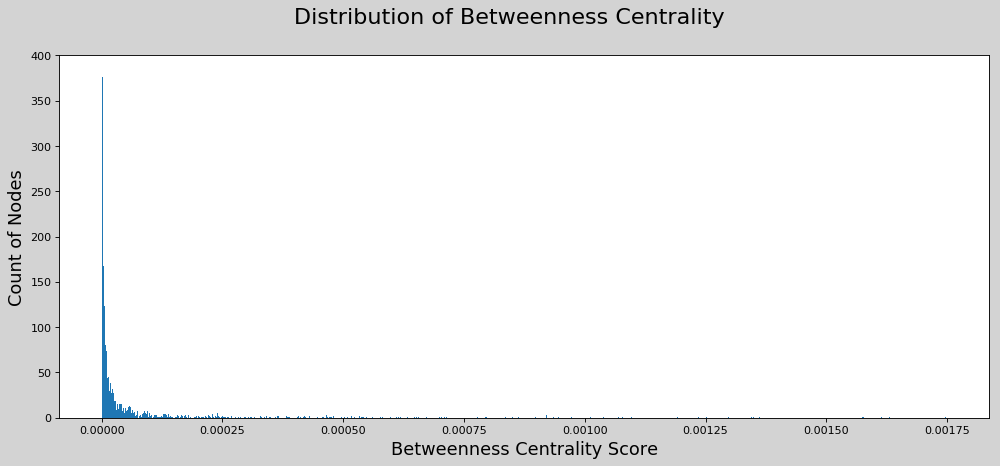

In [179]:
plt.figure(figsize=(15, 6), dpi=80, facecolor='lightgray')
plt.hist(bc_v, bins = list(np.arange(0, 0.00175, 0.000001)))
plt.suptitle('Distribution of Betweenness Centrality', fontsize=20)
plt.xlabel('Betweenness Centrality Score', fontsize=16)
plt.ylabel('Count of Nodes', fontsize=16)
plt.ylim((0,400))
plt.show()

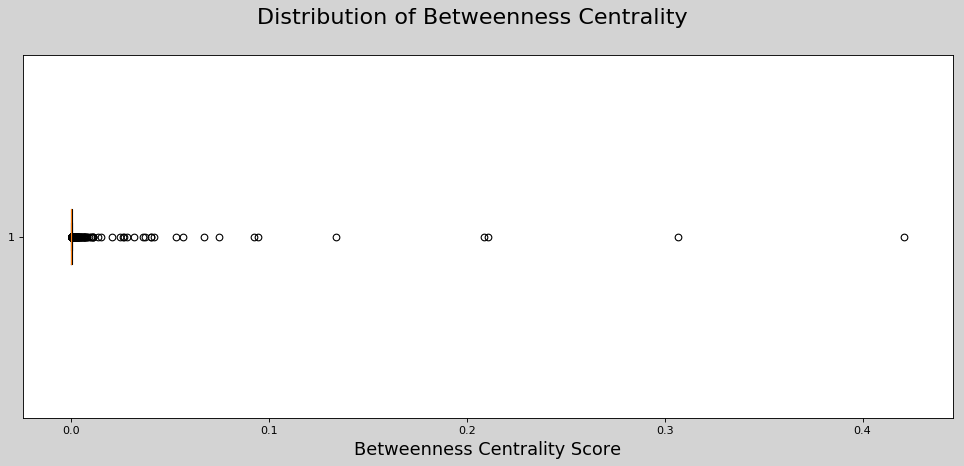

In [180]:
plt.figure(figsize=(15, 6), dpi=80, facecolor='lightgray')
plt.scatter(bc_v,bc_k)
plt.boxplot(bc_v, vert=False)
plt.suptitle('Distribution of Betweenness Centrality', fontsize=20)
plt.xlabel('Betweenness Centrality Score', fontsize=16)
plt.show()

Confirming what we saw with degree centrality, the betweenness centrality scores show us that the majority of nodes are extremely low, suggesting much of the graph is less connected.

_Top Performing BC_

Given this largest network view, lets determine the node with the highest betweenness centrality score. Do do so, we'll make a UDF.

In [36]:
def highest_bet_cent(a):
    
    bc = nx.betweenness_centrality(a)
    
    max_bc = max(list(bc.values()))
    
    nodes = set()
    
    for k, v in bc.items():
        if v == max_bc:
            nodes.add(k)
            
    return (nodes,max_bc)

In [37]:
best_bc_n, best_bc = highest_bet_cent(g)

In [38]:
print("---------------------")
print("Node " +  str(list(best_bc_n)[0]) + " had the highest centrality score of " + str(round(best_bc,4)))
print("---------------------")

---------------------
The 107 node had the highest centrality score of 0.421
---------------------


##### Add Scores to node metadata

Now that we have assessed the degree centrality and betweenness centrality of the various nodes in context of the larger network, we need to add this data to the metadata of the corresponding nodes. Doing so I will also add the suffix '\_big' in order to indicate the scores based on the larger network dataset.

In [330]:
nx.set_node_attributes(g, values=bc, name='betweenness_big')
nx.set_node_attributes(g, values=dc, name='degree_centrality_big')

In [199]:
for i in range(5):
    print("Node " + str(i) + ":" + str(g.node[i]))

Node 0:{'betweenness_big': 0.13382523651261172, 'degree_centrality_big': 0.08568598315998019}
Node 1:{'betweenness_big': 4.463599717680394e-05, 'degree_centrality_big': 0.004210004952947003}
Node 2:{'betweenness_big': 5.564813594255961e-07, 'degree_centrality_big': 0.0024764735017335313}
Node 3:{'betweenness_big': 2.21117453181869e-06, 'degree_centrality_big': 0.004210004952947003}
Node 4:{'betweenness_big': 6.175336450528663e-07, 'degree_centrality_big': 0.0024764735017335313}


#### Statistical Data Exploration: _Conclusion_



Something noticed from the above statistical exploratory analysis is the low connectivity figures to the larger groups, but high connectivity figures with other segments. This implies that our dataset has multiple groups that have little to do with one another, but strong connectivity within.

To understand the general shape of the data we are to work with we will use a MatrixPlot to visualize graphs in a rational fashion. matrix plot returns the matrix form of the graph where each node is one column and one row, and an edge between the two nodes is indicated by the value 1. 

The chart below confirms our statistical analysis, showing that there are separate groups that are largely unconnected to one another in the larger network. 

<Figure size 960x960 with 0 Axes>

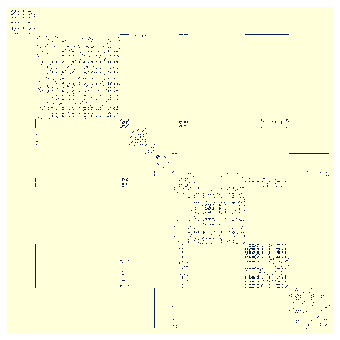

In [602]:
m = nv.MatrixPlot(g)
m.draw()
plt.show()

### Find Communities : _Facebook Network Analysis_

The issue above is one that is anticipated during our development work with poor communities in Perú. These communies will largely be isolated, therefore we need to separate these groups in the larger dataset in order to understand the various communities within a dataset. 


##### Community Detection

The __Girvan–Newman Algorithm__ detects communities by progressively removing edges from the original network. The connected components of the remaining network are the communities. Instead of trying to construct a measure that tells us which edges are the most central to communities, the Girvan–Newman algorithm focuses on edges that are most likely "between" communities, extending on the definition of edge betweenness. 

If there is more than one shortest path between a pair of nodes, each path is assigned equal weight such that the total weight of all of the paths is equal to unity. If a network contains communities or groups that are only loosely connected by a few inter-group edges, then all shortest paths between different communities must go along one of these few edges. Thus, the edges connecting communities will have high edge betweenness. By removing these edges, the groups are separated from one another and so the underlying community structure of the network is revealed.

The algorithm's steps for community detection:

* The betweenness of all existing edges in the network is calculated first.
* The edge with the highest betweenness is removed.
* The betweenness of all edges affected by the removal is recalculated.
* Steps 2 and 3 are repeated until no edges remain.

Definition Source: <a href="https://en.wikipedia.org/wiki/Girvan%E2%80%93Newman_algorithm">Wikipedia</a>

__Process:__ We aim to build generator and add levels until we have a set of communities that we can visually confirm with the larger data exploration process (above). We will then save off the results and view the size of the communities and attempt to understand them before performing analysis on the separate commuities. 

In [184]:
communities_generator = nxc.girvan_newman(g)

In [213]:
top_level_communities = next(communities_generator)
two_level_communities = next(communities_generator)
three_level_communities = next(communities_generator)
four_level_communities = next(communities_generator)
five_level_communities = next(communities_generator)

In [548]:
six_level_communities = next(communities_generator)
seven_level_communities = next(communities_generator)
eight_level_communities = next(communities_generator)
#nine_level_communities = next(communities_generator)

In [573]:
eight_level_communities_output = sorted(map(sorted, eight_level_communities))

In [585]:
print("---------------------")
print("We can see that we have " + str(len(eight_level_communities_output)) + " communities that appeared given the girvan-newman algorithm")
print("The community sizes are " + str([len(x) for x in eight_level_communities_output])[1:-1] + " respectively")
print("---------------------")

---------------------
We can see that we have 9 communities that appeared given the girvan-newman algorithm
The community sizes are 343, 92, 778, 957, 753, 303, 206, 548, 59 respectively
---------------------


In [586]:
eight_level_communities_output_df = pd.DataFrame(eight_level_communities_output)
eight_level_communities_output_df.to_csv('eight_level_communities_output.csv')

#### Separate Communities

Now that we have found 6 communities, we need to add the community identifiers to the metadata of the nodes. I did so by creating a dict with the values 1 through 6 to represent the community id's, then looped through that dict of lists in order to build a dict that was optimized for updating the node attributes in the node set.

In [587]:
community_dict = dict()
make_communities = dict()

for i in range(len(eight_level_communities_output)):
    community_dict.update({i:eight_level_communities_output[i]})

for k, v in community_dict.items():
    for i in v:
        make_communities.update({i:k})

#### Community Identifier to Metadata

Add this new dictionary to the node attributes

In [588]:
nx.set_node_attributes(g, values=make_communities, name='community')

Lets check if it worked...good!

In [589]:
nodes_in_5 = [y for x,y in g.nodes(data=True) if y['community'] == 8]
nodes_in_5[:3]

[{'betweenness_big': 0.025922779258628573,
  'community': 8,
  'degree_centrality_big': 0.014611193660227836},
 {'betweenness_big': 0.0005050365938011509,
  'community': 8,
  'degree_centrality_big': 0.0014858841010401188},
 {'betweenness_big': 0.00013267036455521342,
  'community': 8,
  'degree_centrality_big': 0.0009905894006934125}]

#### Flatten Updated Node List and Save

We are going to do a small exercise here where we turn our node list into a human readable pandas dataframe and then save that dataframe into a file. This creates a great time stamp for our progress thus far, so we don't have to risk the computationally expensive community creation process again.

From this point we also need to keep in mind the end user of our information and our ability to explain this information. As we move forward, we will slowly begin building on this csv file to aggregate our understanding of nodes.

In [590]:
nodelist = []

# Iterate over nodes (n) and their dictionary metadata (d)

for n,d in g.nodes(data=True):
    
    node_data = dict() 
    
    # to uniquely identify value with id (n) of node
    node_data['node'] = n 
    
    # update keys with metadata (d) of node
    node_data.update(d) 
    
    # append nodes record dictionary to the node list
    nodelist.append(node_data)

#the resulting dictionary is now in a list of dictionaries rather than a list of tuples
#once this data structure is created, we can cast the new nodelist into a DF

core_df = pd.DataFrame(nodelist)
core_df = core_df[['node','community','degree_centrality_big','betweenness_big']]

core_df.to_csv('community_partitions.csv')

In [581]:
core_df.head()

,node,community,degree_centrality_big,betweenness_big
0,1,0,0.004210,4.463600e-05
1,0,0,0.085686,1.338252e-01
2,2,0,0.002476,5.564814e-07
3,3,0,0.004210,2.211175e-06
4,4,0,0.002476,6.175336e-07


Lets check if the date transfer worked the same as our node list...good!

In [591]:
nodes_in_8 = core_df[core_df['community'] == 8]
nodes_in_8.head()

,node,community,degree_centrality_big,betweenness_big
1827,3980,8,0.014611,0.025923
1828,3989,8,0.001486,0.000505
1829,4011,8,0.000991,0.000133
1830,4031,8,0.002476,0.000874
3984,3981,8,0.001981,0.000023


#### Visualize Graph with Community Identifiers

Hey, not too bad, we can see by the grouping we have a fairly decent separation of community groups. We can see that there are some inner groupings within communities, but for this deeper analysis we will separate out communities and partition on cliques within. 

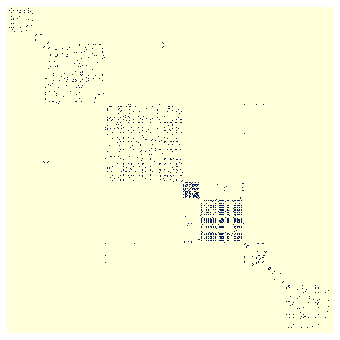

<Figure size 432x288 with 0 Axes>

In [592]:
m = nv.MatrixPlot(g, node_grouping = 'community', node_color = 'community')
m.draw()
plt.show()

from pylab import savefig
savefig('community_group_matrix.png')

#### Visualize High Level Community Metrics

In [596]:
import matplotlib.pyplot as plt
# create number for each group to allow use of colormap
from itertools import count
# get unique groups
groups = set(nx.get_node_attributes(g,'community').values())
mapping = dict(zip(sorted(groups),count()))
nodes = g.nodes()
colors = [mapping[g.node[n]['community']] for n in nodes]

/anaconda/envs/Python36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


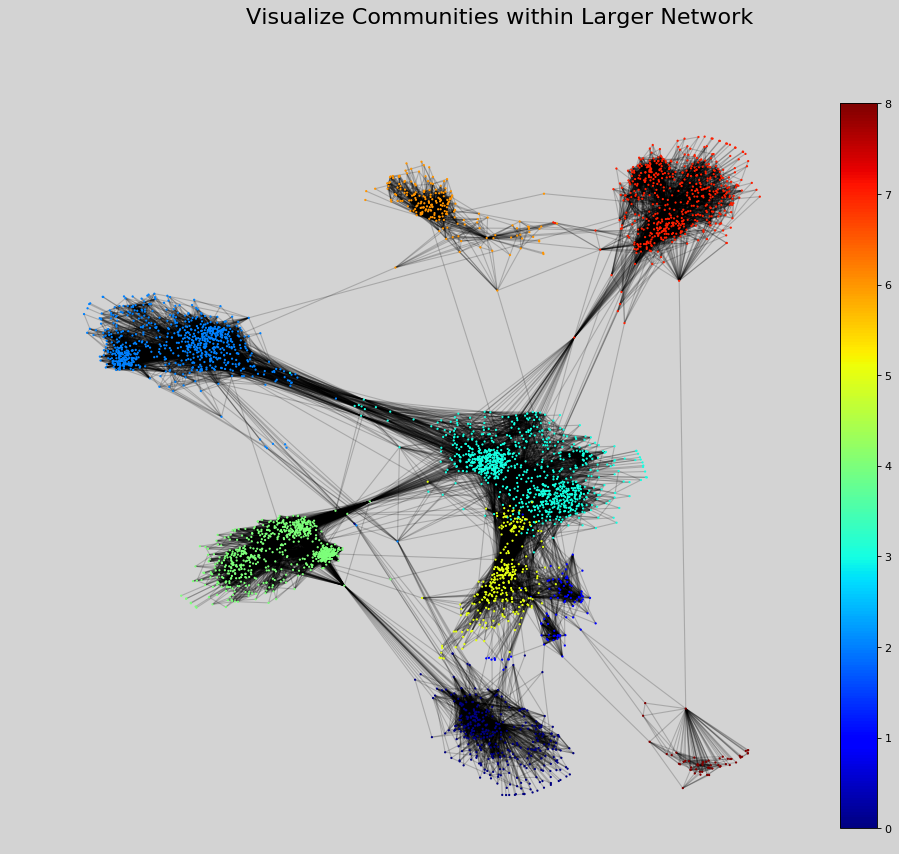

<Figure size 432x288 with 0 Axes>

In [601]:
# drawing nodes and edges separately so we can capture collection for colobar
plt.figure(figsize=(15, 12), dpi=80, facecolor='lightgray')
plt.suptitle('Visualize Communities within Larger Network', fontsize=20)
pos = nx.spring_layout(g)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors,with_labels=False, node_size=1, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()
plt.savefig('community_group_matrix.png')

Wow, this is a beautiful graph to help us visualize the network, that is now divided into communities by color. As we look at this graph we see six clearly defined communities and three in which there are some overlap between the communities. Secondly, we notice connections connections between these communities, often with these specific nodes serving as a conduits to other communities. This confirms our betweenness centrality analysis, where we saw a majority of nodes having low betweenness scores (nodes that exist solely within the smaller community structures) and also nodes with extraordingarily high scores (the conduits). 

Lets dig into this further!

### Understand Communities: _Facebook Network Analysis_
#### Degree Centrality

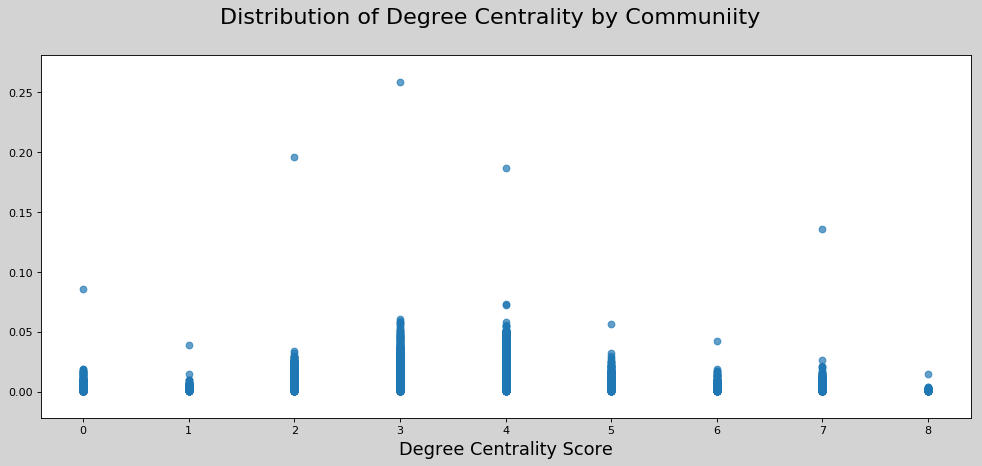

In [610]:
plt.figure(figsize=(15, 6), dpi=80, facecolor='lightgray')
plt.scatter(core_df['community'],core_df['degree_centrality_big'], alpha = 0.7)
plt.suptitle('Distribution of Degree Centrality by Communiity', fontsize=20)
plt.xlabel('Degree Centrality Score', fontsize=16)
plt.show()

#### Betweenness Centrality

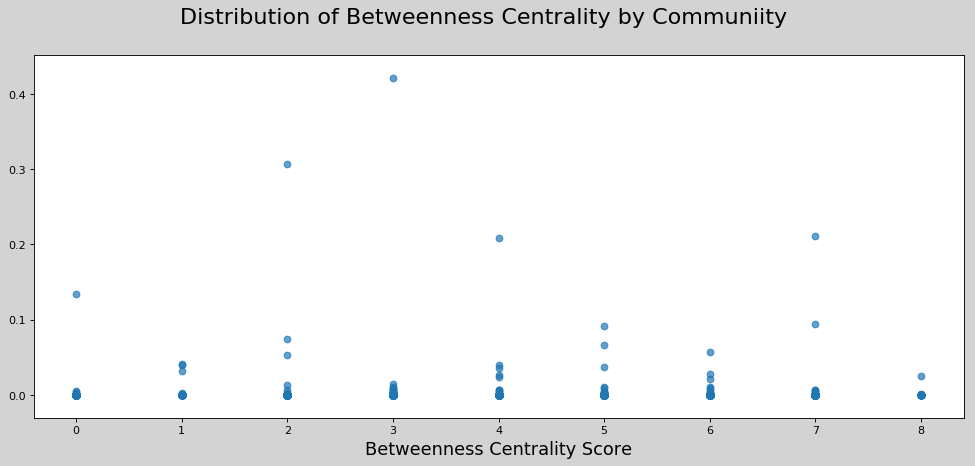

In [609]:
plt.figure(figsize=(15, 6), dpi=80, facecolor='lightgray')
plt.scatter(core_df['community'],core_df['betweenness_big'], alpha = 0.7)
#plt.boxplot(core_df[['community','degree_centrality_big']])
plt.suptitle('Distribution of Betweenness Centrality by Communiity', fontsize=20)
plt.xlabel('Betweenness Centrality Score', fontsize=16)
plt.show()

In [626]:
community_bts = core_df.groupby(core_df.community)[['betweenness_big']].median().reset_index()
community_cnt = core_df.groupby(core_df.community)[['betweenness_big']].count().reset_index()
community_bts['cnt'] = community_cnt['betweenness_big']
community_bts

,community,betweenness_big,cnt
0,0,9.308770e-07,343
1,1,6.274538e-06,92
2,2,6.138516e-06,778
3,3,1.242629e-05,957
4,4,1.087265e-05,753
5,5,2.256395e-05,303
6,6,3.471951e-06,206
7,7,2.340879e-06,548
8,8,2.608598e-07,59


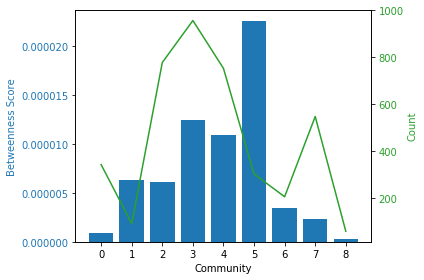

In [651]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Community')
ax1.set_ylabel('Betweenness Score', color=color)
ax1.bar(community_bts['community'], community_bts['betweenness_big'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Count', color=color)  # we already handled the x-label with ax1
ax2.plot(community_bts['community'], community_bts['cnt'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.xticks(np.arange(min(community_bts['community']), max(community_bts['community'])+1, 1.0))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

As we can see by the above graph. The betweenness score is affected by, but far from reliant on, the overall community size. We see community 5 has a high connectivity, but not necesarily so in volume. Additionally, we see that communities 0 and 8 are largely disconnected from the larger network, even with community 0, even with having 343 nodes within. 

#### Influencers by Community

Next, lets look more specifically at the largest influencers by community. Do do this we will run some simple functions on the node data frame we created.

In [754]:
community_inf = core_df.loc[core_df.groupby('community')['betweenness_big'].idxmax()]
community_inf = community_inf[['community','node','betweenness_big']].reset_index(drop=True)
community_inf.to_csv('community_inf.csv')

In the chart below, we have taken the largest influencer (node) in every community. 

Displaying:
 * _Size_ of their influence using betweenness centrality
 * _Community ID_ along the x axis
 * _Node ID_ as the labels

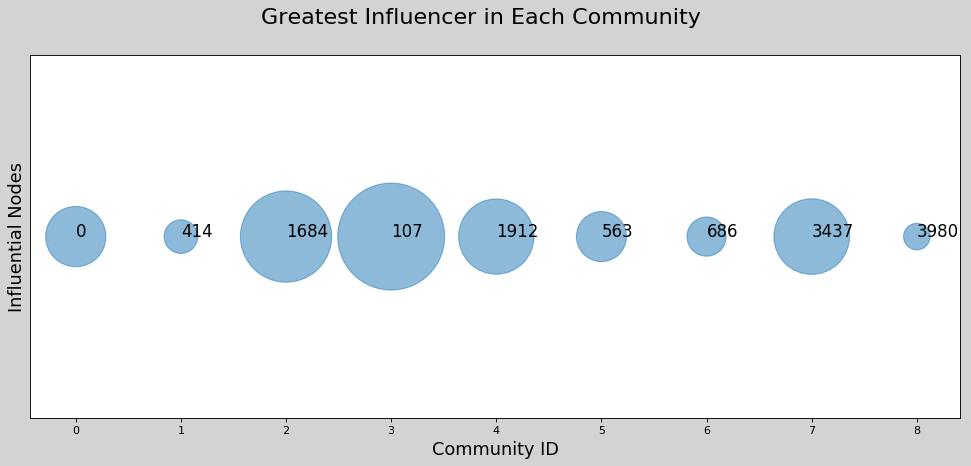

In [756]:
x = list(community_inf['community'])
ns = list(community_inf['node'])
y = [0]*len(x)
s1 = list(community_inf['betweenness_big'])
s2 = [x*22000 for x in s1]

plt.figure(figsize=(15, 6), dpi=80, facecolor='lightgray')
plt.scatter(x,y,s=s2, alpha = 0.5)

for i in range(len(ns)):
    a = x[i]
    b = y[i]
    c = ns[i]
    plt.plot(a, b)
    plt.text(a, b, c, fontsize=15)

plt.suptitle('Greatest Influencer in Each Community', fontsize=20)
plt.yticks([])
plt.xlabel('Community ID', fontsize=16)
plt.ylabel('Influential Nodes', fontsize=16)
plt.show()

### Find Cliques: _Facebook Network Analysis_

Now, we know that we have larger communities, but there is still a lot to understand further around the groups within communities. To do so we will ...


#### Maximal Cliques

#### Visualize Maximal Cliques

#### Add Maximal Cliques Identifiers to Attributes

### Find Triangles: _Facebook Network Analysis_

#### Triangles

Lets see how many triangles exist within the entire network dataset we ingested.

In [757]:
poss_triangles = nx.transitivity(g)
print("---------------------")
print("In the larger network " + str(round(poss_triangles*100,2)) + "% of the nodes exist within a triad.")
print("---------------------")

---------------------
In the larger network 50.46% of the nodes exist within a triad.
---------------------


### Open Triangle Recommendation Engine: _Facebook Network Analysis_
#### Build

#### Build Engine
#### Use Cases

### Community Specific Exploration with Subgraphs: _Facebook Network Analysis_
#### Create Community Subgraphs
#### Visualize
#### Question

### Community Recommendation Engine: _Facebook Network Analysis_
#### Create Bipartite Projection
#### Visualize Bipartite Projection
#### Build Engine
#### Use Cases

### Conclusion 

#### Accomplishments

#### Challenges

* packages surrounding network analysis are still in their infancy and many options still have bugs
* community creation algorithm is very computationally expensive